# 1. Previsão de Vendas

Disponível em: http://faculty.marshall.usc.edu/gareth-james/ISL/data.html

Este notebook apresenta um modelo capaz de prever o Saldo _(Balance)_ do cartão de crédito de acordo com uma série de características dos usuários.

## Sumário

1.		Previsão de Vendas<br>
&nbsp;1.1.	Configuração do Projeto<br>
&nbsp;1.2.	Análise exploratória dos dados<br>
&emsp;&emsp;1.2.1.	Distribuição dos Dados<br>
&emsp;&emsp;&emsp;&emsp;1.2.1.1.Usuários Ativos<br>
&emsp;&emsp;1.2.2.	Gender<br>
&emsp;&emsp;1.2.3.	Student<br>
&emsp;&emsp;1.2.4.	Married<br>
&emsp;&emsp;1.2.5.	Ethnicity<br>
&emsp;&emsp;1.2.6.	Sumário Estatístico<br>
&emsp;&emsp;1.2.7.	Correlações de features numéricas<br>
&emsp;&emsp;1.2.8.	Correlações de features categóricas<br>
&nbsp;1.3.	Insights<br>
&nbsp;1.4.	LabelEncoder<br>
&nbsp;1.5.	Treinamento do modelo<br>
&emsp;&emsp;1.5.1.	Avaliação dos Modelos<br>
&nbsp;1.6.	Aplicação do LinearRegression<br>
&emsp;&emsp;1.6.1.	R^2 Metric<br>
&emsp;&emsp;1.6.2.	Previsões<br>
&emsp;&emsp;1.6.3.	Novas Previsões

## 1.1. Configuração do Projeto

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def distribuicao(df, features, size=(15, 55)):
    """
        Apresenta a distribuição dos dados através do seaborn
    """
    fig = plt.figure(figsize=size)
    nrows = len(df.columns)
    ncols = 2

    for index, feature in enumerate(df[features].columns):
        ax = fig.add_subplot(nrows, ncols, index + 1)
        sns.distplot(df[feature], ax=ax, fit=stats.norm)
    
    
def correlacao(df):
    """
        Apresenta a correlação dos dados através do seaborn
    """
    plt.figure(figsize=(8, 8))

    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, vmax=0.7, cmap=cmap, mask=mask, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True)
    
    
def get_pie_value_counts(series, title=None, colors=None):
    """
        Apresenta um gráfico em pie com o value_counts() de uma feature
    """
    data = series.values
    keys = series.keys()
    
    def func(pct, allvals):
        """
            Apresenta a porcentagem a ser exibida no gráfico
        """
        absolute = int(pct/100. * np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), 
                                      colors=colors)

    ax.legend(wedges, keys,  fontsize=14, bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=14, weight="bold")
    ax.set_title(title)

    plt.show()

## 1.2. Análise exploratória dos dados

Descrição das colunas:

* ID - Identification
* Income - Income in \$10,0000
* Limit - Credit limit
* Rating - Credit rating
* Age - Age in years
* Education - number of years of education
* Gender - Male or Female
* Student - Yes or No
* Married - Yes or No
* Ethnicity - African American, Asian or Caucasian
* Balance - Average credit card balance in $

In [2]:
df = pd.read_csv('Credit.csv', index_col=0, thousands='.', decimal=',')

# Transforma as colunas object para o tipo category
object_columns = df.select_dtypes(include='object').columns
df[object_columns] = df[object_columns].astype('category')

df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104593,7075,514,4,71,11,Male,No,No,Asian,580
4,148924,9504,681,3,36,11,Female,No,No,Asian,964
5,55882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


### 1.2.1. Distribuição dos Dados

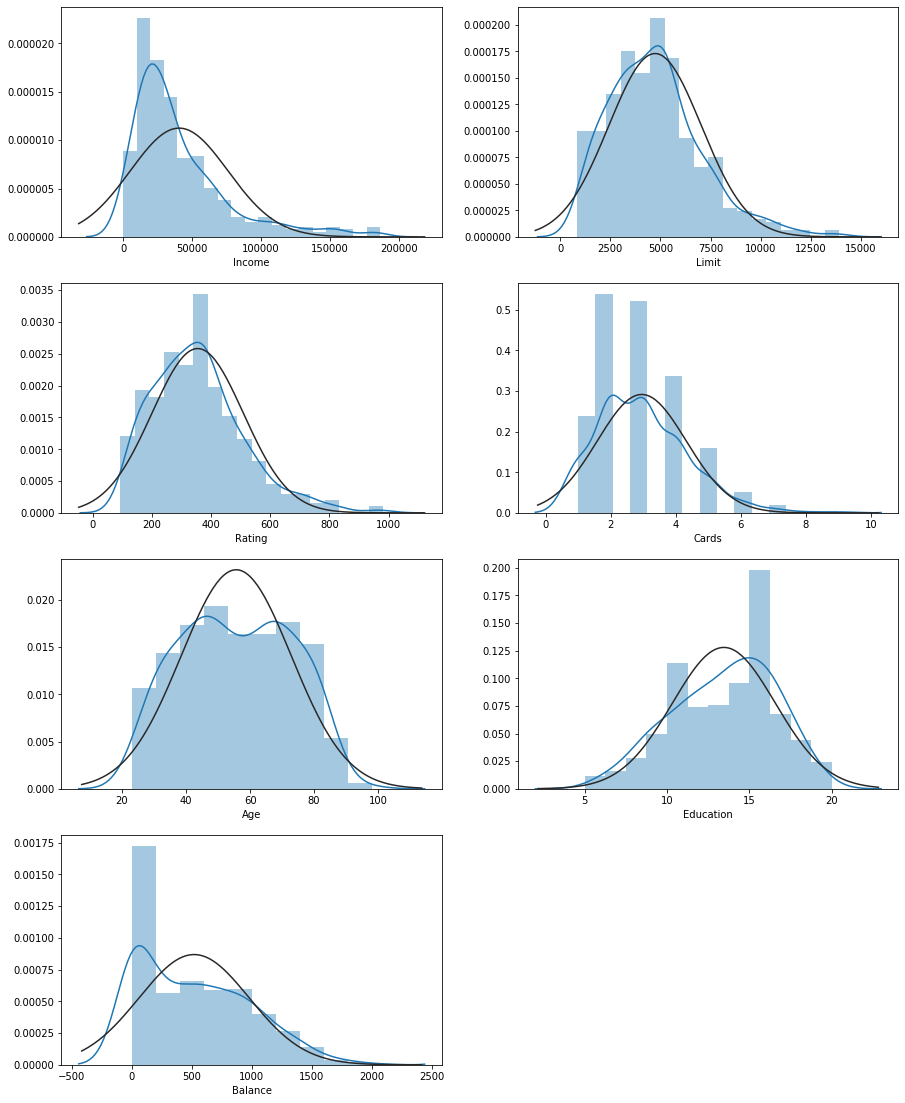

In [3]:
distribuicao(df, df.select_dtypes(exclude='category').columns)

#### 1.2.1.1. Usuários ativos
A feature Balance representa o Saldo da fatura do cartão de crédito.

Se o usuário possui saldo 0, isso significa que o usuário não utiliza o cartão de crédito, portanto estes usuários podem interferir negativamente no resultado da análise.

In [4]:
df_usuarios_ativos = df[df.Balance > 0].copy()
df_usuarios_ativos.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,44911.693548,5485.467742,405.051613,2.996774,55.606452,13.425806,670.987097
std,38283.464621,2052.451743,137.967389,1.426740,17.341794,3.208904,413.904019
min,12.000000,1160.000000,126.000000,1.000000,23.000000,5.000000,5.000000
25%,17817.750000,3976.250000,304.000000,2.000000,42.000000,11.000000,338.000000
50%,33547.000000,5147.000000,380.000000,3.000000,55.500000,14.000000,637.500000
75%,59623.500000,6453.250000,469.000000,4.000000,69.000000,16.000000,960.750000
max,186634.000000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


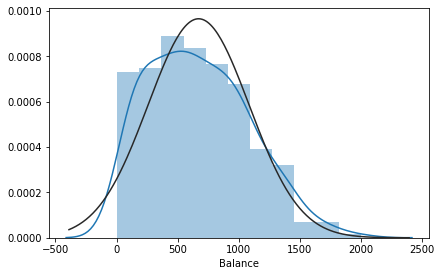

In [5]:
distribuicao(df_usuarios_ativos, ['Balance'])

Após esta conclusão, podemos criar uma nova feature no DataFrame original para indicar se o usuário é ativo ou não.

In [6]:
df['Active'] = np.where(df.Balance > 0, 'Yes', 'No')
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Active
1,14891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,Yes
2,106025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,Yes
3,104593,7075,514,4,71,11,Male,No,No,Asian,580,Yes
4,148924,9504,681,3,36,11,Female,No,No,Asian,964,Yes
5,55882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,Yes


### 1.2.2. Gender

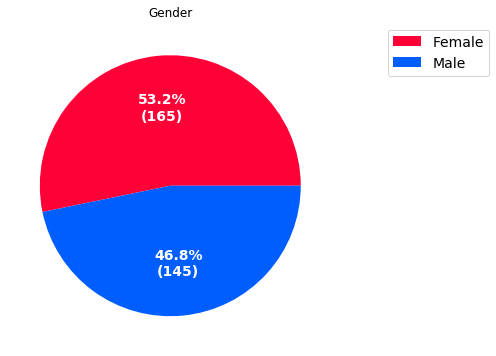

In [7]:
get_pie_value_counts(df_usuarios_ativos['Gender'].value_counts(), title='Gender', colors=['#ff0037', '#005eff'])

### 1.2.3. Student

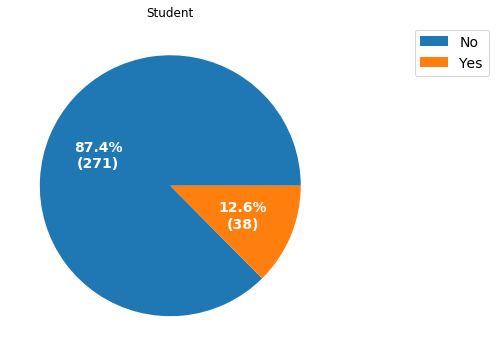

In [8]:
get_pie_value_counts(df_usuarios_ativos['Student'].value_counts(), title='Student')

### 1.2.4. Married

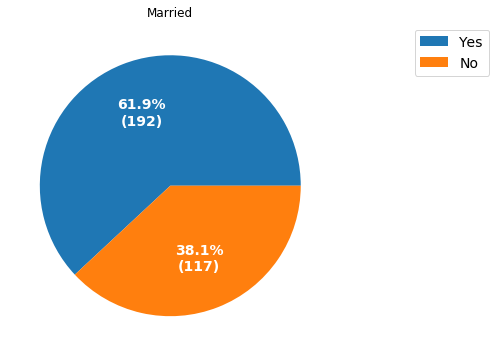

In [9]:
get_pie_value_counts(df_usuarios_ativos['Married'].value_counts(), title='Married')

### 1.2.5. Ethnicity

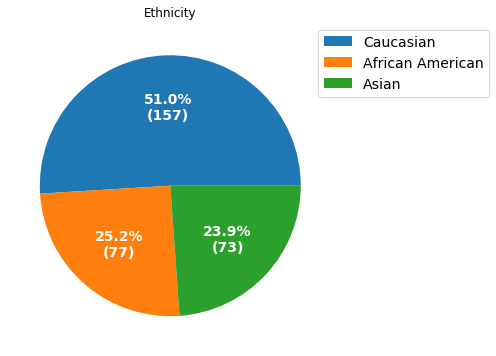

In [10]:
get_pie_value_counts(df_usuarios_ativos['Ethnicity'].value_counts(), title='Ethnicity')

### 1.2.6. Sumário estatístico

In [11]:
df_usuarios_ativos.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,44911.693548,5485.467742,405.051613,2.996774,55.606452,13.425806,670.987097
std,38283.464621,2052.451743,137.967389,1.426740,17.341794,3.208904,413.904019
min,12.000000,1160.000000,126.000000,1.000000,23.000000,5.000000,5.000000
25%,17817.750000,3976.250000,304.000000,2.000000,42.000000,11.000000,338.000000
50%,33547.000000,5147.000000,380.000000,3.000000,55.500000,14.000000,637.500000
75%,59623.500000,6453.250000,469.000000,4.000000,69.000000,16.000000,960.750000
max,186634.000000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


### 1.2.7. Correlações de features numéricas
Analisaremos as features numéricas e suas correlações.

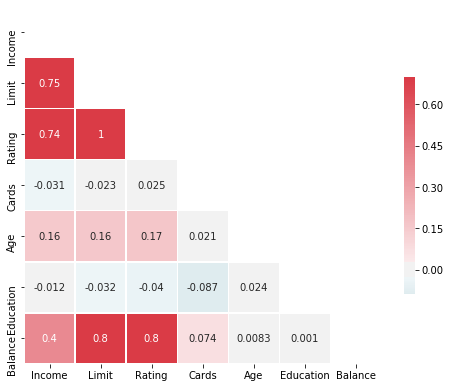

In [12]:
df_numerico = df_usuarios_ativos.select_dtypes(include='number')
correlacao(df_numerico)

### 1.2.8. Correlações de features categóricas
Analisaremos as features categóricas e suas correlações. Observe que há uma expressiva diferença entre estudantes e não-estudantes.

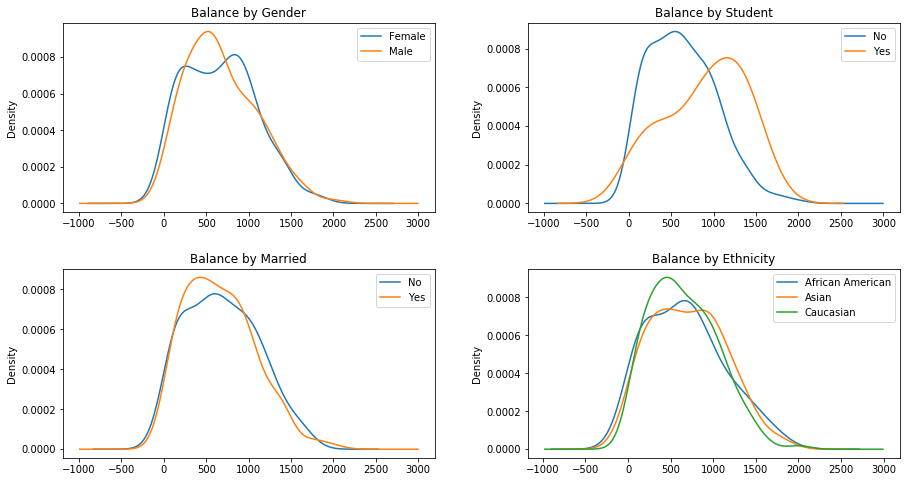

In [13]:
f, axes = plt.subplots(2, 2, figsize=(15, 8))
f.subplots_adjust(hspace=.3, wspace=.25)
df_usuarios_ativos.groupby('Gender').Balance.plot(kind='kde', ax=axes[0][0], legend=True, title='Balance by Gender')
df_usuarios_ativos.groupby('Student').Balance.plot(kind='kde', ax=axes[0][1], legend=True, title='Balance by Student')
df_usuarios_ativos.groupby('Married').Balance.plot(kind='kde', ax=axes[1][0], legend=True, title='Balance by Married')
df_usuarios_ativos.groupby('Ethnicity').Balance.plot(kind='kde', ax=axes[1][1], legend=True, title='Balance by Ethnicity')
plt.show()

## 1.3. Insights

Usuários que não são estudantes gastam mais na medida que seus salários aumentam, porém os estudantes não apresentam um comportamento linear.

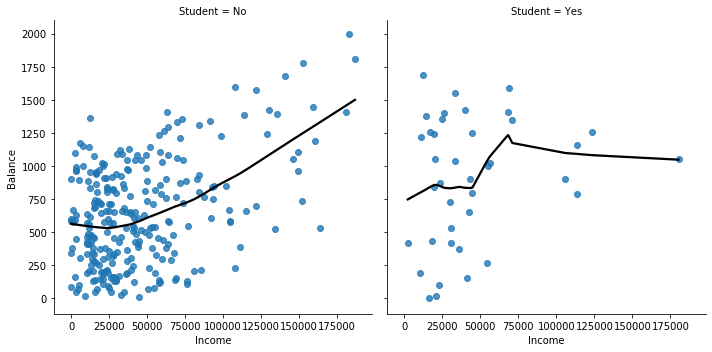

In [14]:
sns.lmplot(x='Income',
          y='Balance',
          data=df_usuarios_ativos,
          line_kws={'color':'black'},
          lowess=True,
          col='Student')

Usuários com salários inferiores tendem a controlar mais os gastos no cartão de crédito. Em contrapartida, usuários com salários mais altos, gastam mais.

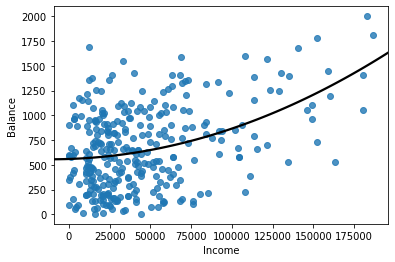

In [15]:
sns.regplot('Income', 'Balance',
           data = df_usuarios_ativos,
           ci=None,
           order=2,
           line_kws={'color':'black'})

Usuários com idades superiores e casados possuem gastos mais controlados.

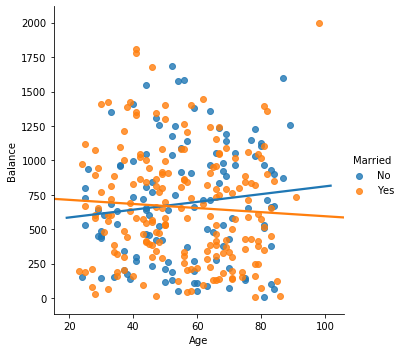

In [16]:
sns.lmplot(x="Age",
           y="Balance",
           hue="Married",
           ci=None,
           data=df_usuarios_ativos)

Mulheres que possuem mais cartões de créditos tendem a gastar mais.

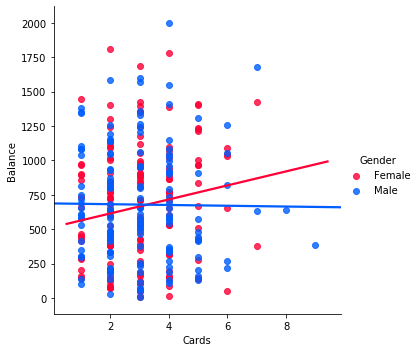

In [17]:
sns.lmplot(x="Cards", 
           y="Balance", 
           hue="Gender", 
           ci=None,
           data=df_usuarios_ativos,
           palette=['#ff0037', '#005eff'])

## 1.4. LabelEncoder
Nesta etapa transformaremos as variáveis categóricas em numéricas.

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in df_usuarios_ativos.select_dtypes(include='category').columns:
    df_usuarios_ativos[col] = encoder.fit_transform(df_usuarios_ativos[col])

df_usuarios_ativos.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14891,3606,283,2,34,11,1,0,1,2,333
2,106025,6645,483,3,82,15,0,1,1,1,903
3,104593,7075,514,4,71,11,1,0,0,1,580
4,148924,9504,681,3,36,11,0,0,0,1,964
5,55882,4897,357,2,68,16,1,0,1,2,331


## 1.5. Treinamento do modelo

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Seleção de features e classe
previsores = df_usuarios_ativos.iloc[:, :-1].values
classe = df_usuarios_ativos['Balance'].values

# Modelos
modelos = {}
modelos['DecisionTree'] = DecisionTreeRegressor()
modelos['RandomForest'] = RandomForestRegressor(n_estimators=100)
modelos['LinearRegression'] = LinearRegression()

# Configuração para o treinamento do modelo
seed = 0
num_folds = 10
resultados = {}

# Treinamento de todos os modelos
for nome, modelo in modelos.items():
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(modelo, previsores, classe, cv=kfold, scoring='neg_mean_squared_error')
    resultados[nome] = cv_results

### Avaliação dos Modelos

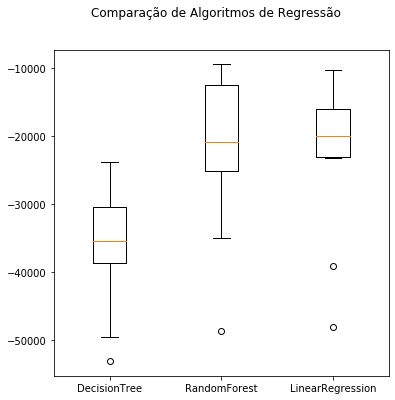

In [20]:
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize=(6, 6))
fig.suptitle('Comparação de Algoritmos de Regressão')

ax = fig.add_subplot(111)

plt.boxplot(resultados.values())
ax.set_xticklabels(resultados.keys())

plt.show()

## 1.6. Aplicação do LinearRegression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle

previsores = df_usuarios_ativos.iloc[:, :-1].values
classe = df_usuarios_ativos['Balance'].values

# Divide a base de dados
X_train, X_test, y_train, y_test = train_test_split(previsores, classe, test_size=0.25, random_state=0)

# Treina o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Salva o modelo
arquivo = 'modelo_linear.sav'
pickle.dump(modelo, open(arquivo, 'wb'))

#### R^2 Metric

In [22]:
print(f'R^2 para LinearRegression: {modelo.score(X_test, y_test)}')

R^2 para LinearRegression: 0.9060784977894808


#### Previsões

In [23]:
# Previsões
previsoes = modelo.predict(X_test)

df_previsoes = pd.DataFrame(X_test, columns=df_usuarios_ativos.iloc[:, :-1].columns)
df_previsoes['Balance'] = y_test
df_previsoes['Balance_Previsoes'] = previsoes
df_previsoes.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Balance_Previsoes
0,19253,3683,287,4,57,10,1,0,0,0,371,332.232870
1,93039,7398,517,1,67,12,1,0,1,0,749,735.731247
2,83948,7100,503,2,44,18,1,0,0,2,806,826.043565
3,51532,5096,380,2,31,15,1,0,1,2,481,509.246097
4,12,4160,320,4,28,14,0,0,1,2,602,644.170224
5,53217,4943,362,2,46,16,0,0,1,1,382,441.902378
6,32793,4534,333,2,44,16,1,0,0,0,467,459.331744
7,15079,5673,411,4,28,15,0,0,1,1,1075,962.336841
8,72945,8603,621,3,64,8,0,0,0,2,1355,1176.609170
9,27229,3484,282,6,51,11,1,0,0,2,265,329.596035


#### Novas previsões

In [24]:
# Income, Limit, Rating, Cards, Age, Education, Gender (Male), Student (No), Married (Yes), Ethnicity (Caucasian)
novos_valores = [24000, 4000, 250, 2, 29, 16, 1, 0, 1, 2]

print(f'Balance: {modelo.predict([novos_valores])[0]:.2f}')

Balance: 531.08
